# Initializing and Importing

In [6]:
# Some standard imports for math and data handling
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# Imports for processing specific to this workbook
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
from datetime import datetime

# Import the custom code developed for this work
sys.path.append('python')
from clusterOutliers import clusterOutliers as coo

%matplotlib inline

In [2]:
def dataScaler(qdf,nfeats=60):
    """
    Data scaler for this work, returns a dataframe w/ scaled features
    """
    data = qdf.iloc[:,0:nfeats]
    scaler = preprocessing.StandardScaler().fit(data)
    scaled_data = scaler.transform(data)
    scaled_df = pd.DataFrame(index=qdf.index,\
                             columns=qdf.columns[:nfeats],\
                             data=scaled_data)
    return scaled_df

In [203]:
def import_generator(suffix='_FullSample.csv',
                     filepath="/home/dgiles/Documents/KeplerLCs/output/",
                    fits_files_directory="/home/dgiles/Documents/KeplerLCs/fitsFiles/"):
    """
    Args:
        suffix (str) - the suffix of the file to be imported
        filepath (optional, str) - filepath to the file to be imported
        fits_files_directory (optional, str) - path to the directory containing the fits files
        
    Returns:
        lambda function that with single str input of the prefix, typically a Q#.
    
    Use:
        Enables simpler import of multiple quarters of data contained 
        in the same location with the same suffixes.
    
    Requirements: 
    import sys
    sys.path.append('python')
    from clusterOutliers import clusterOutliers as coo
    """
    return lambda QN: coo(filepath+QN+suffix,fits_files_directory+QN+"fitsfiles")

In [205]:
qs = ['Q4','Q8','Q11','Q16']
PCA_folder = "/home/dgiles/Documents/KeplerLCs/output/PCA_reductions/"

In [206]:
import_quarter = import_generator(suffix="_FullSample.csv")
import_base = import_generator(suffix="_base", filepath=PCA_folder)
import_90 = import_generator(suffix="_PCA90", filepath=PCA_folder)
import_95 = import_generator(suffix="_PCA95", filepath=PCA_folder)
import_99 = import_generator(suffix="_PCA99", filepath=PCA_folder)

paper_qs = dict(zip(qs,[import_quarter(Q) for Q in qs]))
base_qs = dict(zip(qs,[import_base(Q) for Q in qs]))
pca90_d = dict(zip(qs,[import_90(Q) for Q in qs]))
pca95_d = dict(zip(qs,[import_95(Q) for Q in qs]))
pca99_d = dict(zip(qs,[import_99(Q) for Q in qs]))

In [272]:
import_full = import_generator(suffix='_output.csv')
q4tmp = import_full('Q4').data.index

In [287]:
(base_qs['Q4'].files==base_qs['Q8'].files).all()

True

In [207]:
"""
Have to rearrange Quarter 8 data to match other data, 
some extra columns are present in the paper data and the baseline (originally copied from the paper)
reductions are fine
"""

cols = base_qs['Q8'].data.columns.tolist()
new_cols = cols[:60]+[cols[62]]+cols[60:62]+cols[63:]
base_qs['Q8'].data = base_qs['Q8'].data[new_cols]

cols = paper_qs['Q8'].data.columns.tolist()
new_cols = cols[:60]+[cols[62]]+cols[60:62]+cols[63:]
paper_qs['Q8'].data = paper_qs['Q8'].data[new_cols]

### Saving dataframes

In [208]:
def save_dfs(PCA_folder = "/home/dgiles/Documents/KeplerLCs/output/PCA_reductions/"):
    """
    Save function specific to this workbook.
    
    !!!THIS WILL OVERWRITE EXISTING FILES!!!
    """
    
    for q in pca90_d:
        pca90_d[q].data.to_csv(PCA_folder+q+"_PCA90")
    for q in pca95_d:
        pca95_d[q].data.to_csv(PCA_folder+q+"_PCA95")
    for q in pca99_d:
        pca99_d[q].data.to_csv(PCA_folder+q+"_PCA99")
    for q in base_qs:
        base_qs['q'].data.to_csv(PCA_folder+q+"_base")
    
    return

In [288]:
import_full = import_generator(suffix='_output.csv')
index_converter = lambda inds_to_convert,q_index: q_index[q_index.str.contains('|'.join(inds_to_convert))] # where q_index is a pandas dataframe index object
inds_to_convert = base_qs['Q4'].files

qinds = {Q:index_converter(inds_to_convert,import_full(Q).files) for Q in ['Q4','Q8','Q11','Q16']}

In [300]:
for Q in ['Q4','Q8','Q11','Q16']:
    output_path = '/home/dgiles/Documents/KeplerLCs/output/Analysis/'+Q+'_analysis.csv'
    # Base information: outlier designation, 2 PCA coordinates, distance score in 
    analysis_data = base_qs[Q].data.loc[:,['pca_x','pca_y','db_out','dist_score']]
    analysis_data['PCA90_score'] = pca90_d[Q].data.dist_score.as_matrix()
    analysis_data['PCA95_score'] = pca95_d[Q].data.dist_score.as_matrix()
    analysis_data['PCA99_score'] = pca99_d[Q].data.dist_score.as_matrix()
    analysis_data.index = qinds[Q]
    analysis_data.to_csv(output_path)

In [341]:
for Q in ['Q8','Q11','Q16']:
    output_path = '/home/dgiles/Documents/KeplerLCs/output/Analysis/'+Q+'_analysis.csv'
    # Base information: outlier designation, 2 PCA coordinates, distance score in 
    analysis_data = base_qs[Q].data.loc[:,['pca_x','pca_y','db_out','dist_score']]
    analysis_data['pca_y'] = pca90_d[Q].data.loc[:,'1']
    analysis_data['PCA90_score'] = pca90_d[Q].data.dist_score.as_matrix()
    analysis_data['PCA95_score'] = pca95_d[Q].data.dist_score.as_matrix()
    analysis_data['PCA99_score'] = pca99_d[Q].data.dist_score.as_matrix()
    analysis_data.index = qinds[Q]
    analysis_data.to_csv(output_path)

In [340]:
base_qs['Q16'].data.loc[:,['pca_x','pca_y']][:10]

,pca_x,pca_y
kplr000757076-2013098041711_llc.fits,-0.606941,-0.606941
kplr000757099-2013098041711_llc.fits,4.775488,4.775488
kplr000757137-2013098041711_llc.fits,0.890881,0.890881
kplr000757280-2013098041711_llc.fits,0.358344,0.358344
kplr000757450-2013098041711_llc.fits,0.494931,0.494931
kplr000891901-2013098041711_llc.fits,-0.491953,-0.491953
kplr000891916-2013098041711_llc.fits,1.882717,1.882717
kplr000892107-2013098041711_llc.fits,-0.620398,-0.620398
kplr000892195-2013098041711_llc.fits,-0.809852,-0.809852
kplr000892203-2013098041711_llc.fits,-1.254520,-1.254520


In [308]:
qinds['Q11'][0]

'kplr000757076-2012004120508_llc.fits'

# Scoring

## Distance based

This is essentially the most naive scoring metric given how clusters/outliers are defined. The metric is simply the distance to the k-th neighbor, min-max normalized from 0 to 1.

In [7]:
def dist_score(data,d2s=None,k=59):
    """
    Args:
        data (Numpy array or Pandas dataframe) - Full set of data
        d2s (Numpy array or Pandas dataframe) - Subset of data to be scored
        k (integer) - Neighbor to which the distance is considered the score
        
    Returns:
        scores (Numpy array) - MinMax scaled scores for data in d2s. 
    """
    # For Kepler data common to quarters 4, 8, 11, and 16, k=59 was determined to be useful.
    if type(d2s)==None:
        d2s=data
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree',n_jobs=-1).fit(data)
    distances, indices = nbrs.kneighbors(d2s)
    scores = distances[:,k]
    scores = (scores-scores.min())/(scores.max()-scores.min()) #min max scaled
    # TODO: readjust scaling so that the extreme outliers don't affect scores of the rest.
    # Potentially scale 90th percentile, define all beyond that as having a score of 1.
    
    return list(scores)

In [209]:
def scoreLoop(qdict,full=False):
    startTime = datetime.now()
    scores_dict = dict()
    for Q in adict:
        qStartTime = datetime.now()
        print("Starting {}".format(Q))
        QN = adict[Q]
        data = QN.data
        dims = 0
        for col in data.columns:    
            if col == 'db_out':
                break
            else:
                dims+=1
        print("Scoring {} in {} dimensions".format(Q,dims))
        scaled_data = dataScaler(data,dims)
        if full:
            data_to_score = scaled_data
        else:
            data_to_score = scaled_data[data.db_out==-1] # This verson only scores outliers
        out_scores = dist_score(scaled_data,data_to_score) 
        scores_dict[Q] = out_scores
        print("Time to process {}: {}".format(Q,datetime.now()-qStartTime))

    print("Time to process all quarters: {}".format(datetime.now()-startTime))
    return scores_dict

### Comparing Scores by quarter (Scores for all objects, outlying and otherwise)

Scores have been generated for the baseline and the reductions for each quarter, the time to process has been recorded in the notes in the PCA_Reduction folder. Original cells that processed the full data (rather than just the outliers) have been overwritten by cleaned up code.

In [311]:
Q16b.data.columns

Index(['absmeansecder', 'amp', 'autocorrcoef', 'coeffvar', 'diff_asymm',
       'flatmean', 'flatrat', 'g_asymm', 'kurt', 'len_nmax', 'len_nmin',
       'longtermtrend', 'mad', 'magratio', 'mautocorrcoef', 'maxslope',
       'maxvars', 'maxvarsr', 'mbp', 'meanabsslope', 'meanmedrat',
       'meannslope', 'meanpslope', 'mid20', 'mid35', 'mid50', 'mid65', 'mid80',
       'minslope', 'naiveperiod', 'normamp', 'num_nsdspikes', 'num_nspikes',
       'num_pm', 'num_psdspikes', 'num_pspikes', 'num_zcross',
       'numnegoutliers', 'numout1s', 'numoutliers', 'numposoutliers',
       'oeratio', 'percentamp', 'periodicity', 'periodicityr', 'pstrend',
       'ptpslopes', 'rough_g_asymm', 'roundmean', 'roundrat', 'sautocorrcoef',
       'skews', 'skewslope', 'stdratio', 'stds', 'tflatmean', 'troundmean',
       'varabsslope', 'varslope', 'varss', 'db_out', 'pca_x', 'pca_y',
       'dist_score'],
      dtype='object')

In [313]:
scores_df_16 = pd.DataFrame({
    "Baseline":Q16b.data.dist_score.as_matrix(),
    "PCA90":Q16_pca90.data.dist_score.as_matrix(),
    "PCA95":Q16_pca95.data.dist_score.as_matrix(),
    "PCA99":Q16_pca99.data.dist_score.as_matrix()},
    index=Q16p.data.index)
scores_df_16['rank_baseline']=scores_df.Baseline.rank(ascending=False)
scores_df_16['rank_90']=scores_df.PCA90.rank(ascending=False)
scores_df_16['rank_95']=scores_df.PCA95.rank(ascending=False)
scores_df_16['rank_99']=scores_df.PCA99.rank(ascending=False)

In [315]:
scores_df_16.sort_values(by='rank_90',axis=0)[10:20]

,Baseline,PCA90,PCA95,PCA99,rank_baseline,rank_90,rank_95,rank_99
kplr007021124-2013098041711_llc.fits,0.249532,0.256732,0.256785,0.300193,12.0,11.0,16.0,21.0
kplr011146710-2013098041711_llc.fits,0.267075,0.254859,0.313436,0.401210,9.0,12.0,10.0,8.0
kplr009591503-2013098041711_llc.fits,0.238128,0.250330,0.247871,0.278545,14.0,13.0,18.0,25.0
kplr009899416-2013098041711_llc.fits,0.143071,0.241213,0.252290,0.261633,36.0,14.0,17.0,29.0
kplr007742534-2013098041711_llc.fits,0.245486,0.236647,0.245606,0.323862,13.0,15.0,19.0,18.0
kplr003866709-2013098041711_llc.fits,0.262168,0.236038,0.239024,0.340343,10.0,16.0,20.0,15.0
kplr005545866-2013098041711_llc.fits,0.141876,0.234436,0.275956,0.274795,37.0,17.0,13.0,26.0
kplr005512782-2013098041711_llc.fits,0.148425,0.231014,0.282138,0.287316,33.0,18.0,12.0,22.0
kplr010789273-2013098041711_llc.fits,0.228772,0.230478,0.232253,0.284533,15.0,19.0,22.0,23.0
kplr007988343-2013098041711_llc.fits,0.210369,0.215593,0.219679,0.237053,16.0,20.0,25.0,32.0


In [312]:
scores_df = pd.DataFrame({
    "Paper":Q4p.data.dist_score.as_matrix(),
    "Baseline":Q4b.data.dist_score.as_matrix(),
    "PCA90":Q4_pca90.data.dist_score.as_matrix(),
    "PCA95":Q4_pca95.data.dist_score.as_matrix(),
    "PCA99":Q4_pca99.data.dist_score.as_matrix()},
    index=Q4p.data.index)

In [47]:
scores_df['rank_paper']=scores_df.Paper.rank(ascending=False)
scores_df['rank_baseline']=scores_df.Baseline.rank(ascending=False)
scores_df['rank_90']=scores_df.PCA90.rank(ascending=False)
scores_df['rank_95']=scores_df.PCA95.rank(ascending=False)
scores_df['rank_99']=scores_df.PCA99.rank(ascending=False)

In [144]:
scores_df.sort_values(by='rank_90',axis=0)[:10]

,Baseline,PCA90,PCA95,PCA99,Paper,rank_paper,rank_baseline,rank_90,rank_95,rank_99
KID,,,,,,,,,,
kplr007691527,0.958985,1.000000,1.000000,1.000000,0.958985,3.0,3.0,1.0,1.0,1.0
kplr007679979,0.897389,0.843297,0.915862,0.933211,0.897389,4.0,4.0,2.0,2.0,2.0
kplr007446357,1.000000,0.783049,0.801750,0.851316,1.000000,1.0,1.0,3.0,3.0,3.0
kplr007659570,0.972632,0.647217,0.653950,0.792679,0.972632,2.0,2.0,4.0,4.0,4.0
kplr005772512,0.341698,0.569547,0.568416,0.566186,0.341698,6.0,6.0,5.0,6.0,6.0
kplr009098388,0.331419,0.552533,0.551449,0.549281,0.331419,7.0,7.0,6.0,7.0,7.0
kplr009408009,0.255235,0.425760,0.424839,0.422893,0.255235,14.0,14.0,7.0,8.0,10.0
kplr003440230,0.256871,0.403101,0.411814,0.438758,0.256871,12.0,12.0,8.0,11.0,9.0
kplr007033135,0.363232,0.386684,0.598600,0.687319,0.363232,5.0,5.0,9.0,5.0,5.0


Evidently the PCA reduction impacts even the most outlying points somewhat significantly. Which, though, do we interpret to be more representative of the truth?

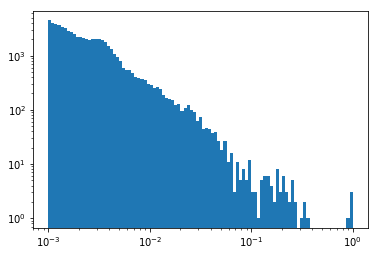

In [219]:
scores = base_qs['Q4'].data.dist_score
bins = np.logspace(-3,0,100)
plt.hist(scores, bins=bins, log=True)
plt.xscale('log')
plt.show()

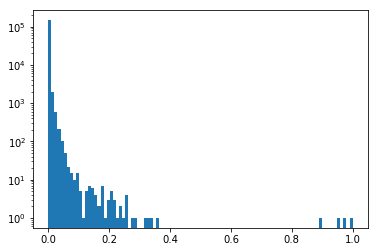

In [223]:
scores = base_qs['Q4'].data.dist_score
bins = np.linspace(0,1,100)
plt.hist(scores, bins=bins, log=True)

plt.show()

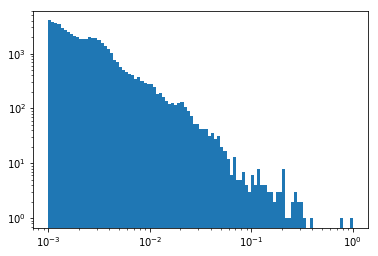

In [220]:
scores = base_qs['Q8'].data.dist_score
bins = np.logspace(-3,0,100)
plt.hist(scores, bins=bins, log=True)
plt.xscale('log')
plt.show()

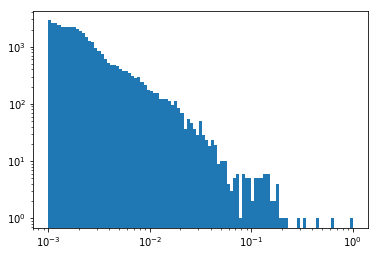

In [221]:
scores = base_qs['Q11'].data.dist_score
bins = np.logspace(-3,0,100)
plt.hist(scores, bins=bins, log=True)
plt.xscale('log')
plt.show()

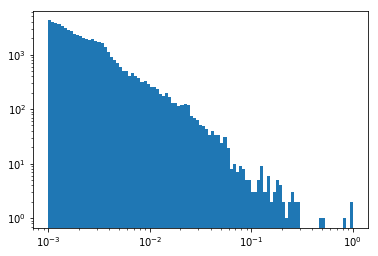

In [222]:
scores = base_qs['Q16'].data.dist_score
bins = np.logspace(-3,0,100)
plt.hist(scores, bins=bins, log=True)
plt.xscale('log')
plt.show()

## Scoring only outliers

#### Scoring the baseline (unreduced) data

In [73]:
def scoreLoop(qdict):
    startTime = datetime.now()
    scores_dict = dict()
    for Q in adict:
        qStartTime = datetime.now()
        print("Starting {}".format(Q))
        QN = adict[Q]
        data = QN.data
        dims = 0
        for col in data.columns:    
            if col == 'db_out':
                break
            else:
                dims+=1
        print("Scoring {} in {} dimensions".format(Q,dims))
        scaled_data = dataScaler(data,dims)
        out_scores = dist_score(scaled_data,scaled_data[data.db_out==-1])
        scores_dict[Q] = out_scores
        print("Time to process {}: {}".format(Q,datetime.now()-qStartTime))

    print("Time to process all quarters: {}".format(datetime.now()-startTime))
    return scores_dict

In [74]:
adict = base_qs
base_out_scores = scoreLoop(adict)

Starting Q4
Scoring Q4 in 60 dimensions
Time to process Q4: 0:00:12.857038
Starting Q8
Scoring Q8 in 60 dimensions
Time to process Q8: 0:00:16.674572
Starting Q11
Scoring Q11 in 60 dimensions
Time to process Q11: 0:00:14.679183
Starting Q16
Scoring Q16 in 60 dimensions
Time to process Q16: 0:00:16.153303
Time to process all quarters: 0:01:00.365658


In [147]:
Q = 'Q16'
df = base_qs[Q].data
out_scores = base_out_scores[Q]
out_only_comp = pd.DataFrame({
    "Full":df[df.db_out==-1].dist_score.as_matrix(),
    "Out_only":out_scores},
    index=df[df.db_out==-1].index)
out_only_comp['rank_full'] = out_only_comp.Full.rank(ascending=False)
out_only_comp['rank_out'] = out_only_comp.Out_only.rank(ascending=False)
rank_diffs = out_only_comp.rank_full - out_only_comp.rank_out
print("""
Greatest rank decrease: {}, {}
Greatest rank increase: {}, {}
Median difference in rank: {}
Percent w/in 10: {:04.1f}%
Percent w/in 100: {:05.2f}%
""".format(rank_diffs.min(), rank_diffs[rank_diffs==rank_diffs.min()].index[0][:13],
          rank_diffs.max(), rank_diffs[rank_diffs==rank_diffs.max()].index[0][:13],
          rank_diffs.median(),
          len(rank_diffs[abs(rank_diffs)<10])/len(rank_diffs)*100,
          len(rank_diffs[abs(rank_diffs)<100])/len(rank_diffs)*100))


Greatest rank decrease: -161.0, kplr007742133
Greatest rank increase: 21.0, kplr005952324
Median difference in rank: 2.0
Percent w/in 10: 75.0%
Percent w/in 100: 99.87%



In [91]:
adict = pca90_d
pca90_out_scores = scoreLoop(adict)

Starting Q4
Scoring Q4 in 18 dimensions
Time to process Q4: 0:00:05.606169
Starting Q8
Scoring Q8 in 18 dimensions
Time to process Q8: 0:00:07.081499
Starting Q11
Scoring Q11 in 17 dimensions
Time to process Q11: 0:00:08.167452
Starting Q16
Scoring Q16 in 17 dimensions
Time to process Q16: 0:00:05.555375
Time to process all quarters: 0:00:26.412719


In [148]:
Q = 'Q16'
df = pca90_d[Q].data
out_scores = pca90_out_scores[Q]
out_only_comp = pd.DataFrame({
    "Full":df[df.db_out==-1].dist_score.as_matrix(),
    "Out_only":out_scores},
    index=df[df.db_out==-1].index)
out_only_comp['rank_full'] = out_only_comp.Full.rank(ascending=False)
out_only_comp['rank_out'] = out_only_comp.Out_only.rank(ascending=False)
rank_diffs = out_only_comp.rank_full - out_only_comp.rank_out
print("""
Greatest rank decrease: {}, {}
Greatest rank increase: {}, {}
Median difference in rank: {}
Percent w/in 10: {:04.1f}%
Percent w/in 100: {:05.2f}%
""".format(rank_diffs.min(), rank_diffs[rank_diffs==rank_diffs.min()].index[0][:13],
          rank_diffs.max(), rank_diffs[rank_diffs==rank_diffs.max()].index[0][:13],
          rank_diffs.median(),
          len(rank_diffs[abs(rank_diffs)<10])/len(rank_diffs)*100,
          len(rank_diffs[abs(rank_diffs)<100])/len(rank_diffs)*100))


Greatest rank decrease: -181.0, kplr009821923
Greatest rank increase: 18.0, kplr002019352
Median difference in rank: 2.0
Percent w/in 10: 78.8%
Percent w/in 100: 99.91%



In [128]:
adict = pca95_d
pca95_out_scores = scoreLoop(adict)

Starting Q4
Scoring Q4 in 23 dimensions
Time to process Q4: 0:00:09.120561
Starting Q8
Scoring Q8 in 24 dimensions
Time to process Q8: 0:00:08.660059
Starting Q11
Scoring Q11 in 22 dimensions
Time to process Q11: 0:00:06.728444
Starting Q16
Scoring Q16 in 23 dimensions
Time to process Q16: 0:00:06.948755
Time to process all quarters: 0:00:31.459481


In [149]:
Q = 'Q16'
df = pca95_d[Q].data
out_scores = pca95_out_scores[Q]
out_only_comp = pd.DataFrame({
    "Full":df[df.db_out==-1].dist_score.as_matrix(),
    "Out_only":out_scores},
    index=df[df.db_out==-1].index)
out_only_comp['rank_full'] = out_only_comp.Full.rank(ascending=False)
out_only_comp['rank_out'] = out_only_comp.Out_only.rank(ascending=False)
rank_diffs = out_only_comp.rank_full - out_only_comp.rank_out
print("""
Greatest rank decrease: {}, {}
Greatest rank increase: {}, {}
Median difference in rank: {}
Percent w/in 10: {:04.1f}%
Percent w/in 100: {:05.2f}%
""".format(rank_diffs.min(), rank_diffs[rank_diffs==rank_diffs.min()].index[0][:13],
          rank_diffs.max(), rank_diffs[rank_diffs==rank_diffs.max()].index[0][:13],
          rank_diffs.median(),
          len(rank_diffs[abs(rank_diffs)<10])/len(rank_diffs)*100,
          len(rank_diffs[abs(rank_diffs)<100])/len(rank_diffs)*100))


Greatest rank decrease: -116.0, kplr001873918
Greatest rank increase: 15.0, kplr005630212
Median difference in rank: 2.0
Percent w/in 10: 84.2%
Percent w/in 100: 99.91%



In [133]:
adict = pca99_d
pca99_out_scores = scoreLoop(adict)

Starting Q4
Scoring Q4 in 35 dimensions
Time to process Q4: 0:00:10.271810
Starting Q8
Scoring Q8 in 36 dimensions
Time to process Q8: 0:00:11.830123
Starting Q11
Scoring Q11 in 34 dimensions
Time to process Q11: 0:00:12.934743
Starting Q16
Scoring Q16 in 34 dimensions
Time to process Q16: 0:00:12.732713
Time to process all quarters: 0:00:47.770770


In [150]:
Q = 'Q16'
df = pca99_d[Q].data
out_scores = pca99_out_scores[Q]
out_only_comp = pd.DataFrame({
    "Full":df[df.db_out==-1].dist_score.as_matrix(),
    "Out_only":out_scores},
    index=df[df.db_out==-1].index)
out_only_comp['rank_full'] = out_only_comp.Full.rank(ascending=False)
out_only_comp['rank_out'] = out_only_comp.Out_only.rank(ascending=False)
rank_diffs = out_only_comp.rank_full - out_only_comp.rank_out
print("""
Greatest rank decrease: {}, {}
Greatest rank increase: {}, {}
Median difference in rank: {}
Percent w/in 10: {:04.1f}%
Percent w/in 100: {:05.2f}%
""".format(rank_diffs.min(), rank_diffs[rank_diffs==rank_diffs.min()].index[0][:13],
          rank_diffs.max(), rank_diffs[rank_diffs==rank_diffs.max()].index[0][:13],
          rank_diffs.median(),
          len(rank_diffs[abs(rank_diffs)<10])/len(rank_diffs)*100,
          len(rank_diffs[abs(rank_diffs)<100])/len(rank_diffs)*100))


Greatest rank decrease: -104.0, kplr005451040
Greatest rank increase: 17.0, kplr001849235
Median difference in rank: 2.0
Percent w/in 10: 88.7%
Percent w/in 100: 99.98%



### Looking at lightcurves

In [58]:
import quarterTools as qt

In [69]:
def import_generator(suffix='_FullSample.csv'):
    return lambda QN: coo("/home/dgiles/Documents/KeplerLCs/output/"+QN+suffix,"/home/dgiles/Documents/KeplerLCs/fitsFiles/"+QN+"fitsfiles")

In [70]:
# Need the full file names, which are stored in Q*_output.csv

import_quarter = import_generator("_output.csv")

Q4_full = import_quarter('Q4')
Q8_full = import_quarter('Q8')
Q11_full = import_quarter('Q11')
Q16_full = import_quarter('Q16')

In [95]:
FullSample = qt.make_sampler(Q4p.data.index)
Q4_full = FullSample(Q4_full.data.index)
Q8_full = FullSample(Q8_full.data)
Q11_full = FullSample(Q11_full.data)
Q16_full = FullSample(Q16_full.data)

In [96]:
Q4p.data.index = Q4_full.index
Q8p.data.index = Q8_full.index
Q11p.data.index = Q11_full.index
Q16p.data.index = Q16_full.index

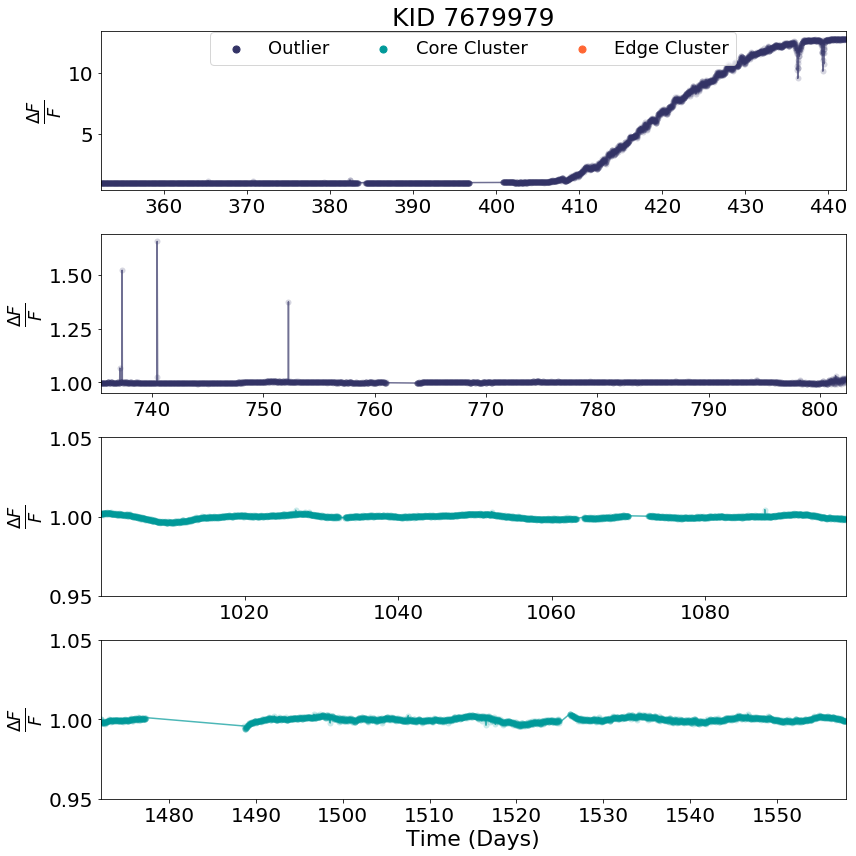

In [145]:
qt.four_Q_lc(scores_df.sort_values(by='rank_paper',axis=0).index[3],Q4p,Q8p,Q11p,Q16p)

In [138]:
def one_Q_lc(kid,Qa):
    fig = plt.figure(figsize=(16,4))
    ax = fig.add_subplot(111)
    title_text = 'KID '+str(int(kid[4:13]))
    plt.title(title_text,fontsize=25)
    sampler =  qt.make_sampler([kid])
    QaID = sampler(Qa.data)
    cs = qt.colors_for_plot([QaID.db_out[0]],cmap='color_blind')
    qt.plot_lc(QaID.index[0],filepath=Qa.fitsDir,c=cs[0],ax=ax)
    ax.set_xlabel('Time (Days)',fontsize=22)
    legend_cs = qt.colors_for_plot([0,1,-1],cmap='color_blind')
    ax.scatter([],[],c=legend_cs[-1],s=50,label='Outlier')
    ax.scatter([],[],c=legend_cs[0],s=50,label='Core Cluster')
    ax.scatter([],[],c=legend_cs[1],s=50,label='Edge Cluster')
    ax.legend(loc='upper center',bbox_to_anchor=(0.5,1.05),ncol=3, fontsize=18)

In [153]:
range(0,-10,-1)[1]

-1

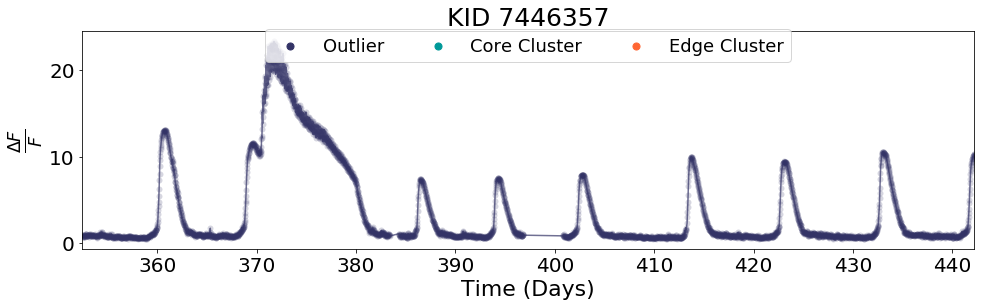

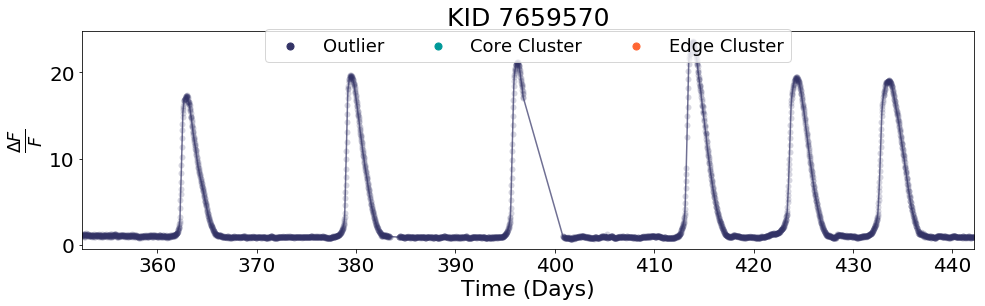

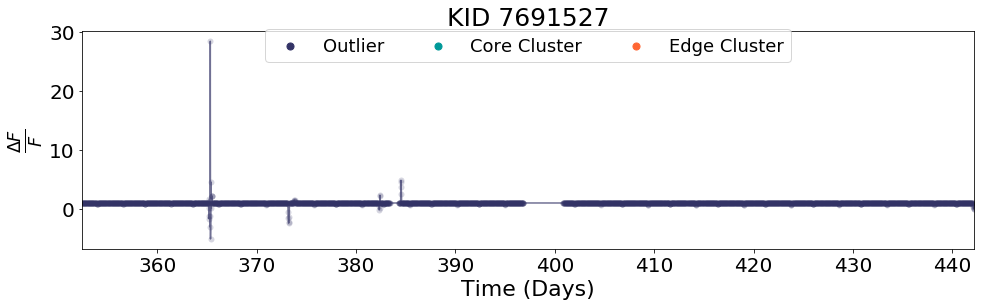

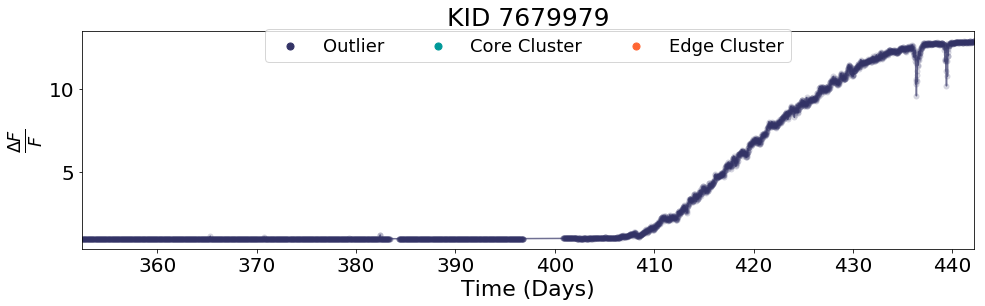

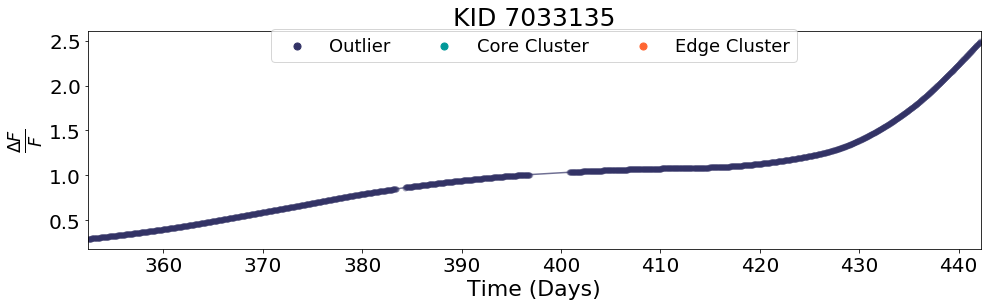

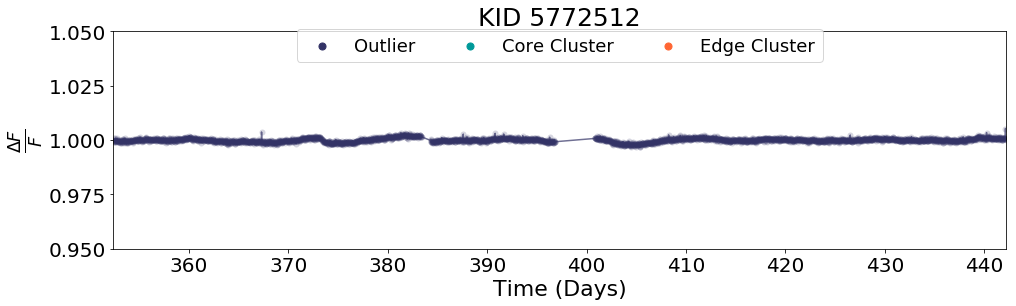

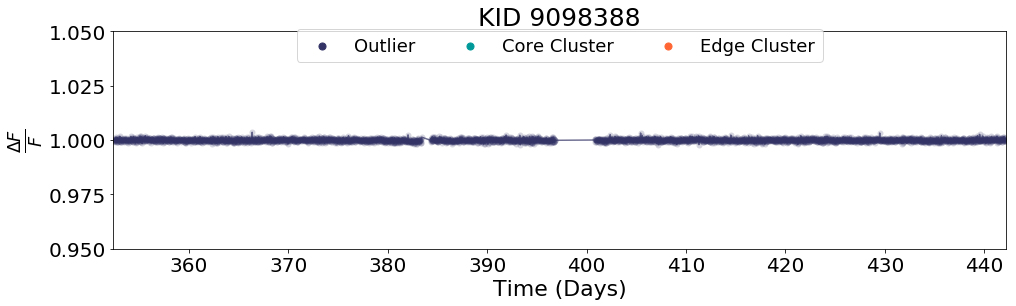

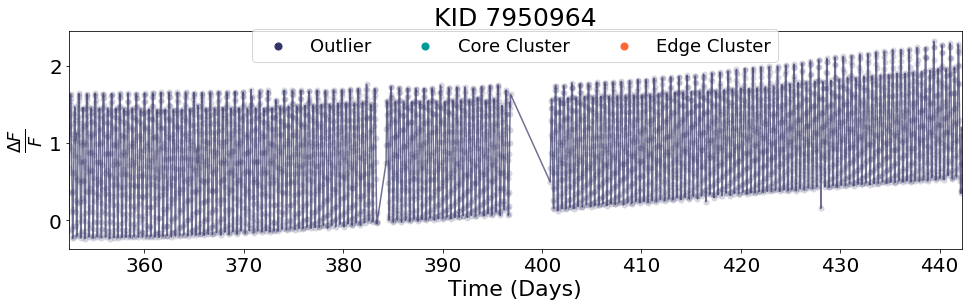

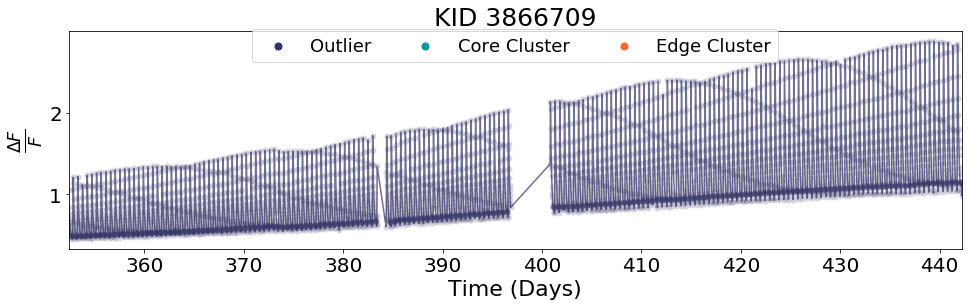

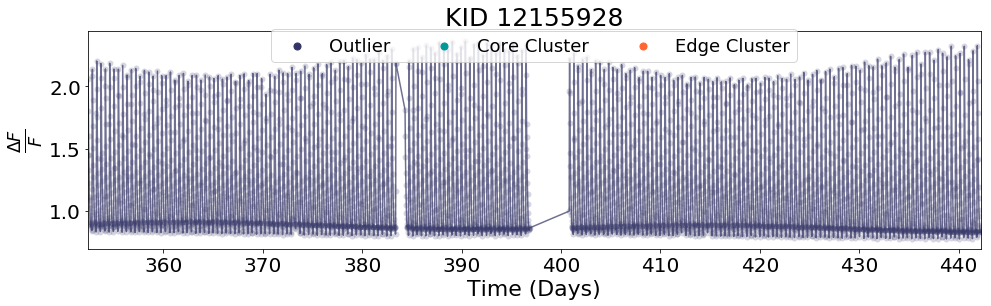

In [202]:
"""
Top 10 outliying lightcurves by baseline score
"""
for i in range(10):
    kid = scores_df.sort_values(by='rank_paper',axis=0).index[i]
    one_Q_lc(kid=kid,Qa=Q4p)


In [9]:
%%timeit
# Only scoring outliers:
startTime = datetime.now()
scaled_data = dataScaler(Q4_pca90.data,18)
out_data = scaled_data[Q4_pca90.data.db_out==-1]
Q4_pca90.out_scores = dist_score(scaled_data,out_data)
print("Time to process: {}".format(datetime.now()-startTime))

Time to process: 0:00:07.226125
Time to process: 0:00:04.924436
Time to process: 0:00:05.032647
Time to process: 0:00:05.042726
Time to process: 0:00:04.951796
Time to process: 0:00:05.492265
Time to process: 0:00:05.650638
Time to process: 0:00:05.619863
5.25 s ± 303 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [214]:
rank_diffs = scores_df.rank_95[Q4p.data.db_out==-1] - scores_df.rank_paper[Q4p.data.db_out==-1]
print("""
Greatest rank decrease: {}, {}
Greatest rank increase: {}, {}
Median difference in rank: {}
Percent w/in 10: {:04.1f}%
Percent w/in 100: {:04.2f}%
Percent w/in 1000: {:05.2f}%
Percent w/in 5000: {:05.2f}%
""".format(rank_diffs.min(), rank_diffs[rank_diffs==rank_diffs.min()].index[0][:13],
          rank_diffs.max(), rank_diffs[rank_diffs==rank_diffs.max()].index[0][:13],
          rank_diffs.median(),
          len(rank_diffs[abs(rank_diffs)<10])/len(rank_diffs)*100,
          len(rank_diffs[abs(rank_diffs)<100])/len(rank_diffs)*100,
          len(rank_diffs[abs(rank_diffs)<1000])/len(rank_diffs)*100,
          len(rank_diffs[abs(rank_diffs)<5000])/len(rank_diffs)*100))


Greatest rank decrease: -1660.0, kplr007122746
Greatest rank increase: 10107.0, kplr008443179
Median difference in rank: -31.0
Percent w/in 10: 02.6%
Percent w/in 100: 22.34%
Percent w/in 1000: 91.80%
Percent w/in 5000: 99.92%



In [192]:
df_tmp = scores_df
df_tmp.index = Q4p.data.index

In [191]:
len(Q_tmp[Q4p.data.db_out==-1])

"""
Issue: Reductions use simplified indices to make comparison across quarters easier (only KIC no timestamp)
This means the data from the paper is not directly comprable.

Solution: Set index of reductions to paper indices here.
"""

'\nIssue: Reductions use simplified indices to make comparison across quarters easier (only KIC no timestamp)\nThis means the data from the paper is not directly comprable.\n\nSolution: Set index of reductions to paper indices here.\n'

In [193]:
pca90_paper_scorediff = df_tmp.PCA90[Q4p.data.db_out==-1] - df_tmp.Paper[Q4p.data.db_out==-1]

print("Min diff: {}, Max diff: {}".format(pca90_paper_scorediff.min(),pca90_paper_scorediff.max()))

Min diff: -0.325414645906953, Max diff: 0.22784832352879897


In [13]:
np.percentile(Q4_pca90.out_scores,90)

0.02660866286119425

Only scoring outliers produces a significant speedup (5s vs 400+s). This does, however, require the prerequisite of already having outliers.

In [117]:
scores = Q4_pca90.data.dist_score[Q4_pca90.data.db_out==-1]
scores = (scores-scores.min())/(scores.max()-scores.min())

In [119]:
score_diff = abs(Q4_pca90.out_scores - scores)
print("""
The absolute maximum difference between scores is {:05.3f}, a {:04.1f}% difference.
""".format(score_diff.max(),score_diff.max()*100))


The absolute maximum difference between scores is 0.002, a 00.2% difference.



In [112]:
score_diff = abs(Q4_pca90.out_scores - Q4_pca90.data.dist_score[Q4_pca90.data.db_out==-1])
print("""
The absolute maximum difference between scores is {:05.3f}, a {:04.1f}% difference.
""".format(score_diff.max(),score_diff.max()*100))


The absolute maximum difference between scores is 0.008, a 00.8% difference.



The difference between scores of the outliers when scoring the whole set versus scoring only the outliers is negligible, producing <1% differences at worst. (1% of the range in which outlier scores are normalized to). The only reason for the difference appears to be where 0 is set.

## Some plots

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

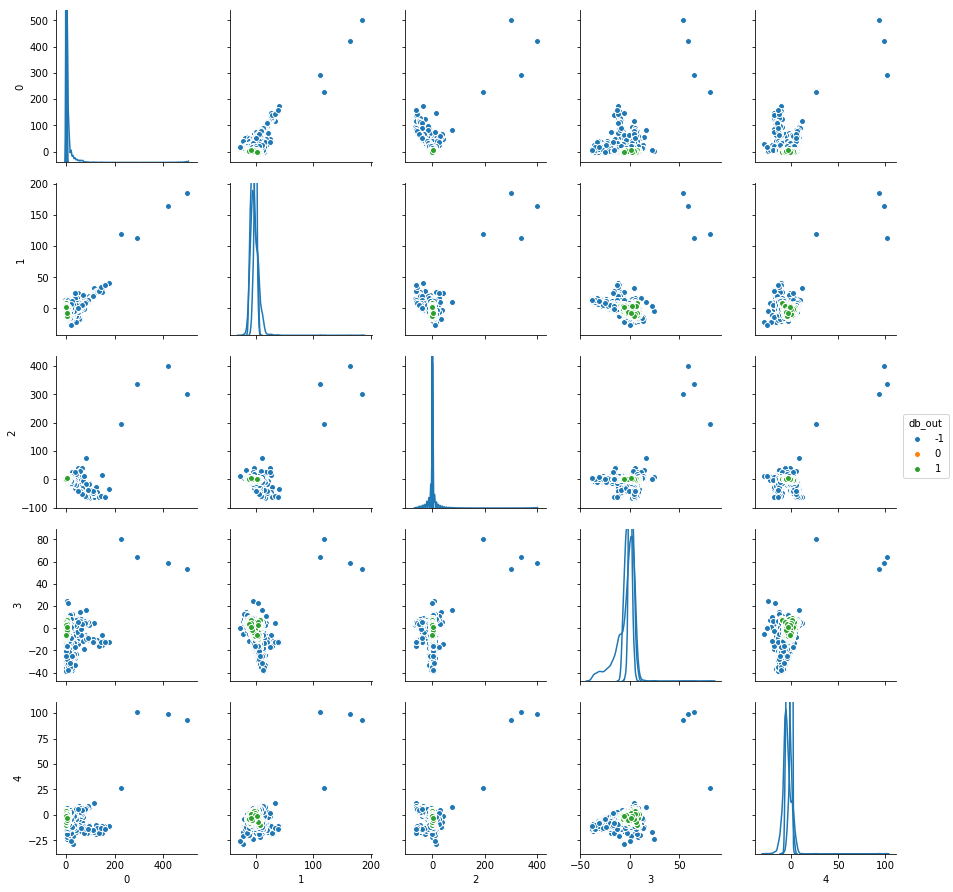

In [213]:
sns.pairplot(Q4_pca90.data,vars=['0','1','2','3','4'],hue='db_out',diag_kind='kde')

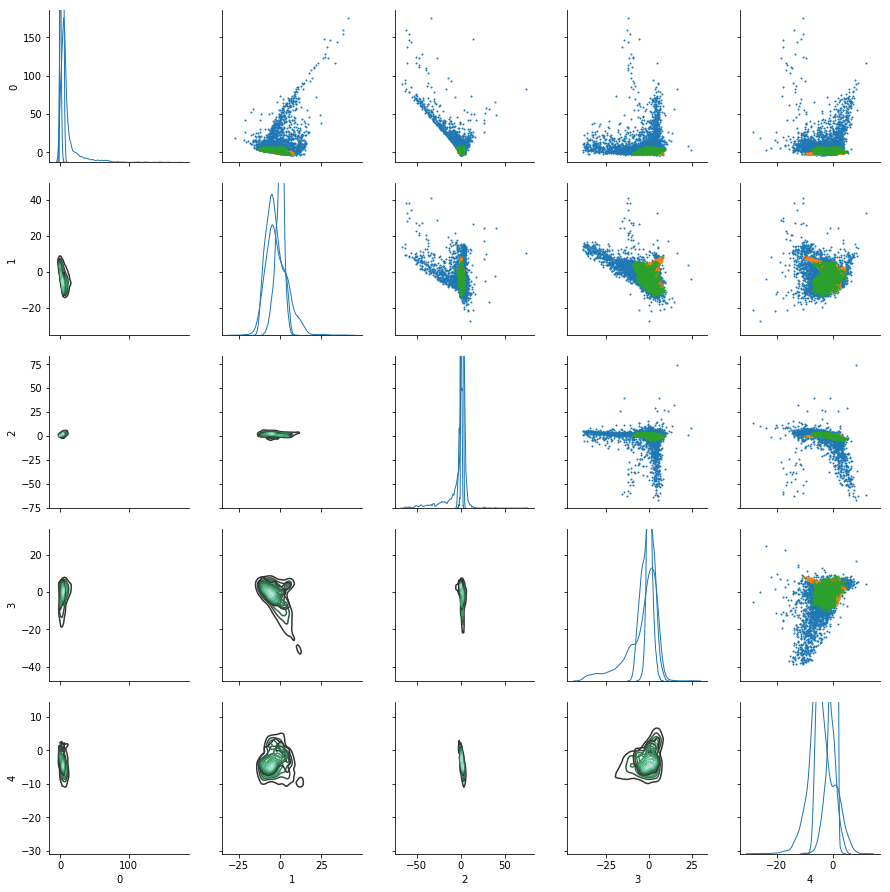

In [215]:
PG = sns.PairGrid(Q4_pca90.data[Q4_pca90.data['1']<75],vars=['0','1','2','3','4'],hue='db_out')
PG.map_lower(sns.kdeplot)
PG.map_upper(plt.scatter, edgecolor=None,s=1)
PG.map_diag(sns.kdeplot, lw=1)

In [216]:
len(scores_df.Paper)

149789